[**Randomized Sampling-Based Fly Local Sensitive Hashing**](https://www.researchgate.net/publication/327994945_Randomized_Sampling-Based_Fly_Local_Sensitive_Hashing) By [Kuan Xu](https://dblp.uni-trier.de/pers/hd/x/Xu:Kuan) and [Yu Qiao](http://automation.sjtu.edu.cn/en/ShowPeople.aspx?info_id=391&info_lb=326&flag=224)

In [426]:
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances

import math

import matplotlib.pyplot as plt

from scipy.spatial import distance

mbyte = 1048576
norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')

In [427]:
from hashlib import md5

def generate_md5(h):
    hmd5 = md5()
    hmd5.update(str(H).encode(encoding='utf-8'))
    return hmd5.hexdigest()

In [2]:
from scipy.linalg import hadamard

In [536]:
%store -r Datasets
data = Datasets['SIFT-10K']
train = data['train']
test = data['test']
n_train = data['n_train']
n_test = data['n_test']
print(data.keys())

dict_keys(['title', 'train', 'test', 'K', 'n_train', 'n_test', 'k_near_neighbors', 'nearest_neighbor'])


# Main


## Center

In [537]:
center = train.mean(axis=0)
train_center = train - center
test_center = test - center

In [539]:
%%time
K = 200
k_near_neighbors = []
for i, q in enumerate(test_center):
    dis = np.array([distance.euclidean(q, p) for p in train_center])
    order_dis = dis.argsort()
    k_near_neighbors.append(order_dis[:K])

CPU times: user 14.6 s, sys: 12.5 ms, total: 14.7 s
Wall time: 14.7 s


## process

In [540]:
def flsh_precision(train, test, s, m, k=4, sigma=None, diagnal=None,
                   near_neighbors=None, K=200,
                   random_state=None, verbose=False):
    """
    Args:
        s: number of select ...  10%
        m: number of Kenyon Cells  20*k, 10*d
        k: Top k (winner take all)
        sigma:
        near_neighbors
        K: k near neighbors
        random_state
        verbose
    """
    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)

    n, d = train.shape
    
    if sigma is None:
        M = rand.choice([0, 1], p=[1-s/d, s/d], size=(m, d))
    else:
        S = np.floor(np.random.normal(s, sigma, (1, m))).astype(np.int)[0]
        S[S < 0] = 1
        S[S > d] = d
        
        M = np.array([np.random.choice([0, 1], p=[1-_s/d, _s/d], size=d) for _s in S])

    if diagnal is not None:
        diag_mat = np.diagflat(rand.choice([-1, 1], p=[0.5, 0.5], size=d))
        H = train.dot(diag_mat).dot(hadamard(d)).dot(M.T)
    else:
        H = train.dot(M.T)
    
    H_order = H.argsort(axis=1)
    for i, h in enumerate(H_order[:, :-k]):
        H[i][h] = 0
        H[i][H[i] != 0] = 1

    precision = []
    for i, q in enumerate(test):
        if diagnal is not None:
            h = M.dot(q.dot(diag_mat).dot(hadamard(d)))
        else:
            h = M.dot(q)

        h[h.argsort()[:-k]] = 0
        h[h != 0] = 1

        dis = np.array([distance.hamming(h, h_) for h_ in H])
        
        precision.append(len(np.intersect1d(dis.argsort()[:K], near_neighbors[i])) / K)

    result = np.array(precision).mean()

    if verbose is True:
        if sigma is not None:
            print('s = {}, m = {}, k = {}, sigma = {}, preicison = {}'.format(s, m, k, sigma, result))
        else:
            print('s = {}, m = {}, k = {}, preicison = {}'.format(s, m, k, result))
        
    return result

In [554]:
n, d = train_center.shape
s = 4
k = 32
m = 10 * d

In [555]:
sigma_arr = np.arange(1, 10.5, 0.5)
sigma_arr

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [543]:
%%time
precision_sigma_with_s4_m10d_k32 = []
for sigma in sigma_arr:
    precision_sigma_with_s4_m10d_k32.append(flsh_precision(train_center, test_center, 
                                        s, m, k, sigma, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1))

CPU times: user 12min 3s, sys: 30.8 s, total: 12min 33s
Wall time: 6min 31s


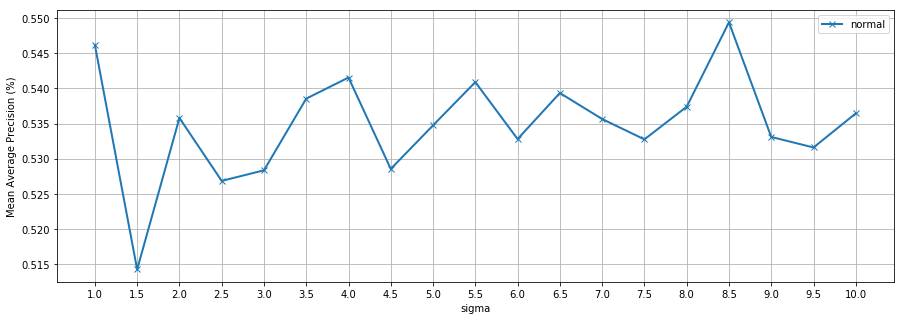

In [544]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'x-', linewidth=2, label='normal')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

In [558]:
n, d = train_center.shape
s = 12
k = 32
m = 10 * d

In [559]:
%%time
precision_sigma_with_s12_m10d_k32 = []
for sigma in sigma_arr:
    precision_sigma_with_s12_m10d_k32.append(flsh_precision(train_center, test_center, 
                                        s, m, k, sigma, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1))

CPU times: user 11min 51s, sys: 29.7 s, total: 12min 21s
Wall time: 6min 17s


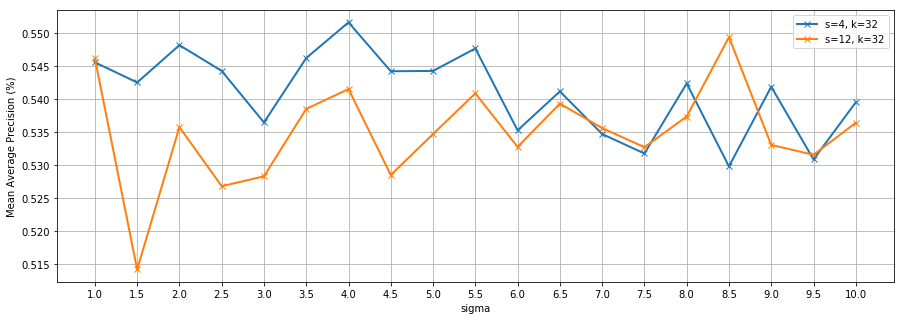

In [560]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_sigma_with_s12_m10d_k32, 'x-', linewidth=2, label='s=4, k=32')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'x-', linewidth=2, label='s=12, k=32')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

In [556]:
n, d = train_center.shape
s = 4
k = 64
m = 10 * d

In [557]:
%%time
precision_sigma_with_s4_m10d_k64 = []
for sigma in sigma_arr:
    precision_sigma_with_s4_m10d_k64.append(flsh_precision(train_center, test_center, 
                                        s, m, k, sigma, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1))

CPU times: user 11min 59s, sys: 30.4 s, total: 12min 29s
Wall time: 6min 24s


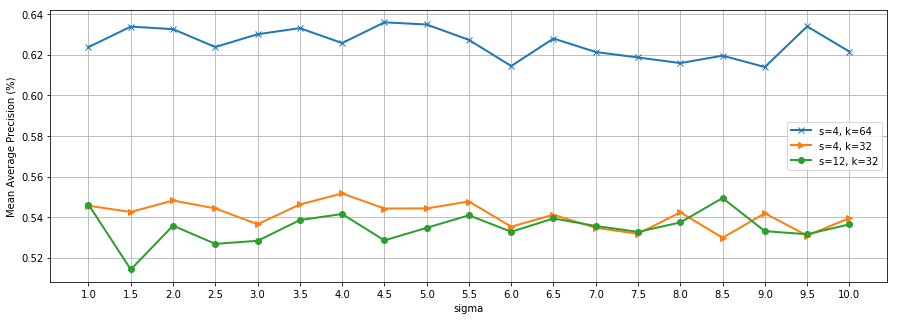

In [561]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64')
plt.plot(sigma_arr, precision_sigma_with_s12_m10d_k32, '>-', linewidth=2, label='s=4, k=32')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'o-', linewidth=2, label='s=12, k=32')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

### original

In [17]:
n, d = train_center.shape
s = 4
k = 64
m = 10 * d

In [18]:
%%time
precision_with_s4_m10d_k64 = []
for sigma in sigma_arr:
    precision_with_s4_m10d_k64.append(flsh_precision(train_center, test_center, 
                                        s, m, k,
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1))

CPU times: user 12min 33s, sys: 32.3 s, total: 13min 5s
Wall time: 6min 50s


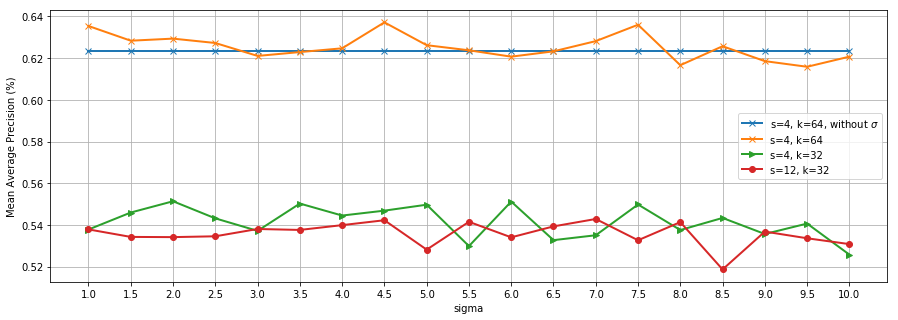

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64, without $\sigma$')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64')
plt.plot(sigma_arr, precision_sigma_with_s12_m10d_k32, '>-', linewidth=2, label='s=4, k=32')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k32, 'o-', linewidth=2, label='s=12, k=32')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

### FJLT

In [20]:
n, d = train_center.shape
s = 4
k = 64
m = 10 * d

In [21]:
%%time
precision_fjlt_with_s4_m10d_k64 = []
for sigma in sigma_arr:
    precision_fjlt_with_s4_m10d_k64.append(flsh_precision(train_center, test_center, 
                                        s, m, k, diagnal=True, 
                                        near_neighbors=k_near_neighbors, 
                                        random_state=1))

CPU times: user 11min 57s, sys: 30.2 s, total: 12min 27s
Wall time: 6min 23s


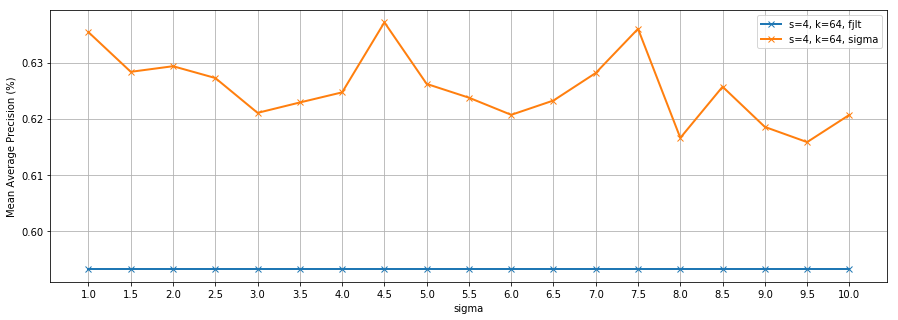

In [138]:
plt.figure(figsize=(15, 5))
plt.plot(sigma_arr, precision_fjlt_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64, fjlt')
plt.plot(sigma_arr, precision_sigma_with_s4_m10d_k64, 'x-', linewidth=2, label='s=4, k=64, sigma')
plt.xticks(sigma_arr)
plt.grid()
plt.xlabel('sigma')
plt.ylabel('Mean Average Precision (%)')
plt.legend(fontsize=10)
plt.show()

**What?**

# Data dependent

## Step 1: $s$, $sum$, $m$

In [327]:
s = 4
n, d = train_center.shape
m = 10 * d

In [328]:
M = np.random.choice([0, 1], p=[1-s/d, s/d], size=(m, d))

# S = np.floor(np.random.normal(s, sigma, (1, m))).astype(np.int)[0]
# S[S < 0] = 1
# S[S > d] = d

# M = np.array([np.random.choice([0, 1], p=[1-_s/d, _s/d], size=d) for _s in S])

In [165]:
S = np.array([np.floor(np.random.normal(s, 1)) for i in range(m)])

In [166]:
S[S <= 0] = 1

In [167]:
S = S.astype(np.int)

In [168]:
S

array([3, 3, 4, ..., 4, 3, 3])

In [169]:
M_idxs = np.array([np.random.choice(np.arange(d), p=weights, size=_s) for _s in S])

In [170]:
M_idxs

array([array([42, 95, 18]), array([ 70, 112,  78]),
       array([111, 126,  50,  84]), ..., array([ 69, 110, 104, 112]),
       array([46, 66, 80]), array([95, 95, 46])], dtype=object)

In [171]:
M = np.zeros((m, d))

In [172]:
for i, idxs in enumerate(M_idxs):
    M[i][idxs] = 1

In [ ]:
M = np.random.choice(np.arange(d), p=weights, size=(m, s))

In [173]:
M

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
M[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [495]:
H = train_center.dot(M.T)
H

array([[ -37.5243,  -41.8709, -160.4456, ...,  -23.4135,  -15.0013,
          63.8535],
       [  63.4757,  -59.8709, -137.4456, ...,    8.5865,  -25.0013,
          85.8535],
       [ -35.5243,  -59.8709, -162.4456, ...,  -52.4135,  -26.0013,
          24.8535],
       ...,
       [ -54.5243,  -18.8709, -127.4456, ...,  -69.4135,  -55.0013,
          10.8535],
       [ -55.5243,  -39.8709,   23.5544, ...,   75.5865,  162.9987,
         -41.1465],
       [ -33.5243,  112.1291,  207.5544, ...,   10.5865,   85.9987,
          25.8535]])

In [468]:
k = 128

In [469]:
D = 129

In [459]:
H_order = H.argsort(axis=1)

H_new = []
for i, h in enumerate(H_order[:, -k:]):
    idxs = np.sort(idxs)
    h = []
    for i in range(10):
        idx = np.argwhere(idxs // 128 == i)
        if len(idx) != 0:
            h.append(idx[0][0])
        else:
            h.append(-1)
    for idx, i in enumerate(h):
        if i == -1:
            h[idx] = h[(idx + 1) % 10] + D
    H_new.append(h)

In [484]:
steps = np.linspace(0, 1280, 11).astype(np.int)
steps

array([   0,  128,  256,  384,  512,  640,  768,  896, 1024, 1152, 1280])

In [496]:
H = np.abs(H)

In [497]:
H_new = []
for i, h in enumerate(H):
    h_new = []
    for j in range(10):
        h_new.append(h[steps[j]:steps[j+1]].argmax())
    H_new.append(h_new)

In [498]:
H_new

[[2, 98, 69, 113, 40, 1, 125, 124, 2, 59],
 [11, 1, 123, 123, 123, 38, 38, 4, 78, 10],
 [70, 98, 85, 105, 15, 1, 125, 18, 2, 108],
 [11, 98, 123, 123, 123, 90, 38, 4, 78, 1],
 [119, 98, 85, 103, 40, 1, 65, 17, 2, 108],
 [10, 68, 61, 123, 40, 0, 71, 4, 79, 93],
 [26, 1, 42, 113, 127, 1, 125, 124, 2, 89],
 [2, 68, 97, 83, 121, 38, 38, 4, 78, 108],
 [36, 49, 42, 2, 121, 1, 12, 77, 62, 64],
 [60, 98, 72, 105, 40, 31, 12, 4, 103, 80],
 [36, 114, 42, 105, 121, 38, 125, 12, 24, 64],
 [2, 127, 61, 123, 40, 31, 12, 4, 21, 80],
 [119, 98, 97, 50, 40, 15, 110, 24, 24, 108],
 [10, 68, 61, 123, 40, 41, 71, 4, 32, 93],
 [11, 68, 123, 90, 123, 38, 38, 18, 13, 89],
 [110, 67, 91, 105, 39, 4, 76, 18, 83, 40],
 [21, 67, 61, 2, 69, 1, 125, 18, 90, 59],
 [13, 77, 48, 90, 86, 69, 54, 23, 79, 93],
 [36, 114, 42, 102, 121, 1, 125, 12, 24, 64],
 [2, 77, 42, 123, 40, 31, 12, 4, 21, 80],
 [36, 67, 42, 2, 121, 1, 125, 77, 85, 108],
 [60, 87, 72, 105, 40, 31, 24, 4, 103, 80],
 [83, 4, 102, 29, 40, 24, 5, 36, 39, 

In [499]:
H_new = np.array(H_new)

In [500]:
H_new

array([[  2,  98,  69, ..., 124,   2,  59],
       [ 11,   1, 123, ...,   4,  78,  10],
       [ 70,  98,  85, ...,  18,   2, 108],
       ...,
       [ 60,  67,  39, ...,  86,  32,   1],
       [ 78,  15,  18, ...,  68,  40,  59],
       [  2, 125, 102, ...,  25,  50, 107]])

In [502]:
tags = H_new.T

In [503]:
tags

array([[  2,  11,  70, ...,  60,  78,   2],
       [ 98,   1,  98, ...,  67,  15, 125],
       [ 69, 123,  85, ...,  39,  18, 102],
       ...,
       [124,   4,  18, ...,  86,  68,  25],
       [  2,  78,   2, ...,  32,  40,  50],
       [ 59,  10, 108, ...,   1,  59, 107]])

In [505]:
# 统计每个 k 各数据的数量，以便计算密度
count_column = np.array([np.bincount(tags[i]) for i in range(10)])

In [511]:
count_column

array([array([  0,  38, 687,  28,   9,   1,  86,  36,  68,  93,  67,  78,   0,
       215,   0,  81, 102,  13,   8,  63,   0, 181,  20,   0, 158,  66,
       232,  17, 350,   2,  69,  17,  94, 182,  15,   3, 473,   4,  28,
        32,   4,  94,  83, 489,  11, 129,  61,  20,   3,   3,  84,   0,
         0,  15,   2,  22, 497,   0,   2,   2, 931,   1,   0,  26,  53,
        30,   2,   1, 102, 153, 283,  35,   0, 234,   6,   2, 128,   5,
         9,  19,  22,  18,   0, 193,  83,  17, 101, 165, 481,  74,   2,
       243,  14,  26,   0,  63,  21,  30,  41,   0,  63, 126,  38,  22,
        62,   0,  27,   0,   0,  33, 153,  12,  12,   1,  13,   8,  15,
         0,   4, 248,   7, 201,  53,  11,   0,  47,   6,  87]),
       array([  13,   60,   18,  323,  241,    6,    3,   14,   29,    0,    2,
         22,    7,    6,  237,   35,    0,   24,  105,  105,    3,   49,
          0,    0,    0,  252,  104,    9,   19,   10,    3,    0,    2,
         30,   35,   20,    6,  183,    0,   27,    1, 

In [517]:
trees = dict()

In [518]:
for i, h in enumerate(H_new):
    rho = []
    for j in range(10):
        rho.append(count_column[j][h[j]])
    rho = np.array(rho)
    idx = h[rho.argmax()]
    if idx not in trees:
        trees[idx] = [i]
    else:
        trees[idx].append(i)

In [535]:
len(trees[4])

17

In [521]:
trees.keys()

dict_keys([40, 38, 98, 1, 108, 105, 18, 90, 59, 57, 9, 60, 50, 54, 104, 48, 2, 72, 76, 12, 112, 32, 41, 56, 67, 43, 125, 39, 97, 4, 122, 44, 42, 58, 88, 77, 36, 78, 103, 55, 84, 24, 64, 28, 102, 83, 25, 93, 113, 13, 70, 124, 89, 96, 121, 29, 75, 107, 31, 14, 73, 66, 101, 23, 26, 15, 3, 0, 91, 80, 45, 119, 110, 79, 95, 49, 65, 35, 85, 81, 53])

In [501]:
euclidean_distances(H_new)[0][1:].min()

52.172789842982326

In [377]:
H_order[:, -k:][0] // 128

array([9, 9, 9, 0, 4, 9, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3, 6, 3, 4, 5,
       4, 4, 5, 4, 5, 5, 5, 5, 5, 4, 3, 0, 3, 6, 0, 9, 8, 1, 1, 1, 8, 8,
       1, 1, 1, 1, 3, 1, 7, 7, 2, 2, 7, 2, 2, 2, 7, 7, 6, 2, 8, 4])

In [349]:
k = 64

In [356]:
%%time
H_order = H.argsort(axis=1)

for i, h in enumerate(H_order[:, :-k]):
    H[i][h] = 0
    H[i][H[i] != 0] = 1

precision = []

for i, q in enumerate(test_center):
    h = M.dot(q)
    
    h[h.argsort()[:-k]] = 0
    h[h != 0] = 1

    dis = np.array([distance.hamming(h, h_) for h_ in H])
    
    precision.append(len(np.intersect1d(dis.argsort()[:5 * K], k_near_neighbors[i])) / K)

result = np.array(precision).mean()

0.071875
0.071875
0.0640625
0.06875
0.065625
0.0734375
0.071875
0.0578125
0.0671875
0.065625
0.0703125
0.0578125
0.0640625
0.0640625
0.0703125
0.0625
0.06875
0.0671875
0.0703125
0.065625
0.0578125
0.0640625
0.0625
0.0640625
0.0609375
0.0734375
0.0640625
0.0609375
0.0609375
0.0625
0.071875
0.0703125
0.0671875
0.08125
0.0734375
0.0734375
0.075
0.0796875
0.0703125
0.0609375
0.0703125
0.0625
0.071875
0.06875
0.0609375
0.0640625
0.0625
0.0765625
0.075
0.0640625
0.0734375
0.0671875
0.059375
0.0625
0.0640625
0.0671875
0.0640625
0.0625
0.078125
0.05625
0.06875
0.0671875
0.0671875
0.0640625
0.0734375
0.0640625
0.071875
0.0734375
0.0625
0.075
0.059375
0.071875
0.078125
0.075
0.0640625
0.0765625
0.0765625
0.0796875
0.06875
0.0578125
0.071875
0.0734375
0.071875
0.06875
0.065625
0.084375
0.071875
0.078125
0.06875
0.059375
0.0578125
0.075
0.0828125
0.0640625
0.075
0.078125
0.0765625
0.075
0.059375
0.0765625
CPU times: user 37.3 s, sys: 1.75 s, total: 39 s
Wall time: 19.9 s


In [351]:
result

0.9712999999999998

**SHD**

In [562]:
k = 64

In [563]:
q = min((np.log(n) ** 2) / d, 1)
q

0.6627372638097999

In [564]:
S = np.random.choice([0, 1], p=[1-q, q], size=(m, d)) * np.random.normal(0, 1/q, (m, d))

In [565]:
H = hadamard(128)

In [566]:
D = np.diagflat(np.random.choice([-1, 1], size=(d)))

In [567]:
Hashing = train_center.dot(D).dot(H).dot(S.T)

In [568]:
Hashing

array([[-6.25035722e+02,  2.04411358e+03,  5.84321924e+00, ...,
        -1.71329814e+03, -3.67203971e+02, -7.25755982e+02],
       [-3.59057912e+03, -1.51656547e+03, -1.49816866e+02, ...,
        -1.16753956e+02,  3.99039160e+02,  1.95347101e+03],
       [-2.97702289e+03, -3.50152399e+02, -2.98384253e+03, ...,
        -3.40931206e+03,  1.67569106e+03, -1.77761006e+03],
       ...,
       [ 5.60701508e+03,  5.33533862e+03,  7.82893877e+03, ...,
         7.65180459e+03, -2.92257831e+03,  2.21748791e+03],
       [ 7.57928520e+03,  4.95765651e+03, -3.73353796e+03, ...,
        -1.19588377e+03, -4.96322466e+03,  2.49812179e+03],
       [ 4.11815546e+03,  1.43997933e+03,  3.10821564e+03, ...,
        -4.13227327e+03, -4.68053116e+03, -2.16265392e+03]])

In [569]:
%%time
H_order = Hashing.argsort(axis=1)

for i, h in enumerate(H_order[:, :-k]):
    Hashing[i][h] = 0
    Hashing[i][Hashing[i] != 0] = 1

precision = []

for i, q in enumerate(test_center):
    h = q.dot(D).dot(H).dot(S.T)
    
    h[h.argsort()[:-k]] = 0
    h[h != 0] = 1

    dis = np.array([distance.hamming(h, h_) for h_ in Hashing])

    precision.append(len(np.intersect1d(dis.argsort()[:K], k_near_neighbors[i])) / K)

result = np.array(precision).mean()

CPU times: user 35.6 s, sys: 1.44 s, total: 37.1 s
Wall time: 18.9 s


In [570]:
result

0.6383000000000001